## 배터리 최적화(LP최적화)

### 데이터 전처리

In [238]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd


# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)
clearDay = data['clearDay'].flatten().reshape(-1, 1)
loadData = data['loadData'][:, 2].reshape(-1, 1) * 10e-5
costData = data['costData'].flatten().reshape(-1, 1)

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )


자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


### 데이터 처리

In [253]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1 # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

battEnergy = 100 * 33.33 # [kW]
Einit = 0.5 * battEnergy
batteryMinMaxEmax = 0.9 * battEnergy
batteryMinMaxEmin = 0.2 * battEnergy
batteryMinMaxPmin = -14.813333333333333
batteryMinMaxPmax = 14.813333333333333

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))

# cloudyPpv = panelArea * panelEff * np.tile(cloudyDay[1::stepAdjust], (numDays, 1))
clearPpv =  np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1))

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt

print(type(N))
print(type(dt))
print(type(Ppv))
# NumPy 배열을 MATLAB으로 전달
Ppv = matlab.double(Ppv.tolist())
print(type(Pload))
# NumPy 배열을 MATLAB으로 전달
Pload = matlab.double(Pload.tolist())
print(type(Einit))
print(type(C))
# NumPy 배열을 MATLAB으로 전달
C = matlab.double(C.tolist())
print(type(FinalWeight))
print(type(batteryMinMaxEmax))
print(type(batteryMinMaxEmin))
print(type(batteryMinMaxPmin))
print(type(batteryMinMaxPmax))

# # MATLAB Engine 시작
eng = matlab.engine.start_matlab()

result = eng.HydroSolarOptimize(N, dt, Ppv, Pload, Einit, C, FinalWeight, batteryMinMaxEmax, batteryMinMaxEmin, batteryMinMaxPmin, batteryMinMaxPmax, nargout=3)
# result = eng.HydroSolarOptimize(N, dt, Ppv, Pload, Einit, C, FinalWeight, batteryMinMaxEmax, batteryMinMaxEmin, nargout=3)
Pgrid = np.array(result[0])
Pbatt = np.array(result[1])
Ebatt = np.array(result[2])

eng.quit()

/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_53512/1302222186.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


<class 'float'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'numpy.ndarray'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


### 그래프 출력

/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_53512/3137440025.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0, 0.5, 'ESS[kW]')

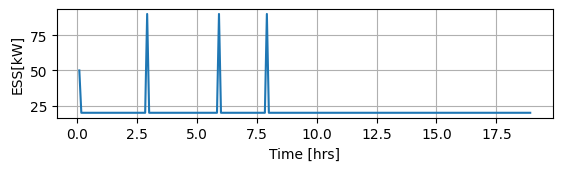

In [254]:
import matplotlib.pyplot as plt

thour = tvec / 3600

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, (Ebatt / battEnergy)* 100)
plt.grid(True)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
 
plt.xlabel('Time [hrs]')
plt.ylabel('ESS[kW]')

Text(0, 0.5, 'ESS')

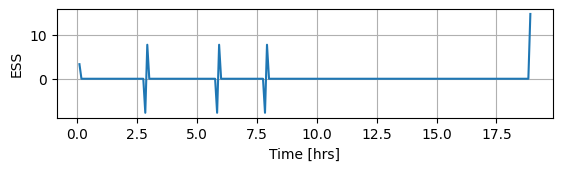

In [255]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pbatt)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('ESS')

Text(0, 0.5, 'Grid')

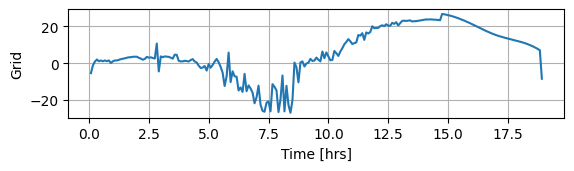

In [256]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Pgrid)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid')

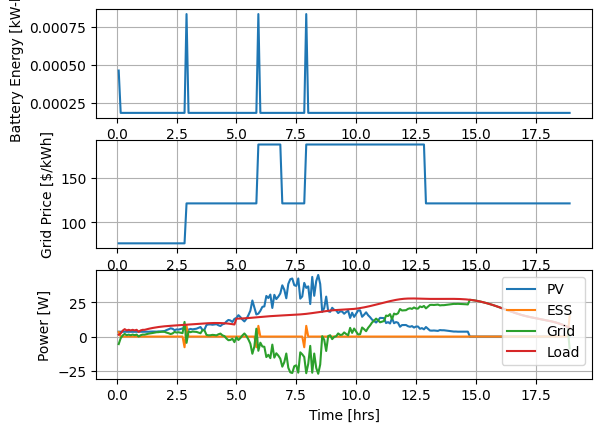

In [257]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, Ebatt / 3.6e6)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Battery Energy [kW-h]')

plt.subplot(3, 1, 2)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.subplot(3, 1, 3)
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(thour, Ppv, thour, Pbatt, thour, Pgrid, thour, Pload)
plt.grid(True)
plt.legend(['PV', 'ESS', 'Grid', 'Load'])
plt.xlabel('Time [hrs]')
plt.ylabel('Power [W]')

plt.show()


### 비용 계산

In [258]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

In [259]:
cumulativeCost

array([-34.86762, -42.55879, -37.23089, -24.91316, -18.59306, -9.56170,
       -3.36910, 5.78976, 12.23736, 21.26872, 21.40719, 27.59979,
       36.63115, 45.53500, 56.65997, 70.16685, 85.14608, 101.65781,
       120.15811, 140.22397, 160.61705, 182.34369, 204.44742, 226.36767,
       244.62482, 260.15142, 271.78968, 286.23651, 307.77973, 326.37683,
       346.34251, 363.97235, 379.71914, 447.51620, 401.39778, 438.27390,
       470.48234, 507.06796, 542.71143, 576.81823, 606.44863, 630.76176,
       677.07351, 722.37961, 734.46261, 743.50084, 753.08748, 765.48054,
       776.45422, 785.09881, 801.79992, 823.39250, 832.15079, 835.38035,
       821.18006, 794.19612, 769.36004, 753.20363, 712.04405, 706.72997,
       681.28941, 670.69892, 678.79956, 701.42585, 706.30682, 685.28299,
       632.49034, 506.28337, 433.45705, 491.15753, 330.15604, 260.48698,
       148.02049, 32.42852, -200.03589, -406.94548, -651.52393,
       -743.00358, -981.75111, -1171.06777, -1386.48216, -1636.94337,
   

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

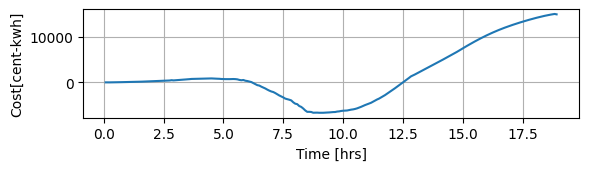

In [260]:
plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [261]:
cumulativeCost[-1]

14991.3854596956

In [262]:
print(Ppv.tolist())
print(Pload.tolist())
print((Ppv-Pload).tolist())
print(Pgrid.tolist()) # 그리드에서 공급하는거
print(Pbatt.tolist()) # 배터리에서 전력 입출력 Emax, Emin 에너지 확실
print(Ebatt.tolist()) # 에너지 상태 에너지 확실

[[3.51], [3.49], [3.45], [3.45], [3.47], [3.47], [3.49], [3.45], [3.45], [3.47], [3.47], [3.49], [3.47], [3.49], [3.53], [3.51], [3.6], [3.65], [3.6], [3.59], [3.75], [3.73], [3.84], [4.02], [4.73], [5.28], [6.0], [5.66], [4.64], [5.19], [5.06], [5.51], [5.89], [5.59], [5.33], [4.99], [5.56], [5.24], [5.45], [5.72], [6.28], [6.92], [4.85], [5.05], [8.43], [8.81], [8.82], [8.59], [8.76], [9.0], [8.19], [7.67], [8.88], [9.34], [10.95], [12.07], [11.68], [10.61], [12.84], [13.53], [15.55], [14.13], [12.35], [11.0], [12.86], [15.54], [18.81], [26.21], [21.06], [16.05], [16.67], [18.72], [21.59], [21.91], [29.52], [27.99], [30.51], [20.79], [30.33], [27.25], [29.01], [31.34], [37.24], [34.05], [27.81], [38.23], [41.67], [42.2], [37.33], [36.8], [42.25], [27.57], [29.14], [38.99], [35.36], [36.48], [23.63], [43.35], [29.62], [40.28], [44.77], [38.2], [17.87], [20.69], [29.04], [18.41], [17.97], [20.91], [19.41], [19.05], [17.08], [18.26], [18.16], [16.58], [17.82], [18.82], [13.54], [17.3], 

In [263]:
Pload == (Ppv + Pgrid + Pbatt)

array([[False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [